In [1]:
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

from pydantic import BaseModel, Field
from pydantic_core import ValidationError
from typing import List, Annotated
from typing_extensions import TypedDict
from operator import add

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [4]:
srs_creator_gpt4o = ChatOpenAI(model="gpt-4o", temperature=0)

In [5]:
software_string = """Snake game"""
software_reqs = """- The game should be implemented in Python using the pygame module.
- The player controls a snake with the goal of eating apples randomly scattered around the game area without hitting the borders of the area or itself.
- If the player eats an apple, the snake grows in size by 1 unit.
- At any time, only 1 apple is present, if the player eats the apple, a new apple appears randomly, but it cannot appear on the snake.
- If the player hits itself or the border of the area, the game ends.
- The performance is measured by the number of consumed apples as a highscore.
- The game plays at a consistent speed that is not too fast.
- The game window has a resolution of 600x600.
- The game is initialized with a snake having a head and one bodypart and a randomly placed apple.
- The game starts when the player hits the space button.
- The player can control the snake with the arrow keys.
- The snake can go north, east, west, and south, but it cannot make 180 degree turns. For example, if the sanke goes north and wants to turn to south, it first has to turn either to west or east.
- The game window should provide options to start a new game and exit the application.
- The game area should be black, the head of the snake dark green, the body parts of the snake light green, and the apples red."""

In [6]:
srs_system_prompt = """You are an experienced software architect. You help with softwer requirements specification (SRS) creation.
An SRS is a document containing specifications for a piece of software. It covers the following areas:
- Problem background
- Stakeholders / Users
- Functional requirements
- Performance requirements
- Design constraints
- External interfaces
- Security requirements
- Uses cases for the application
- A glossary of terms

A use case highlights the flow of the application to accomplish a particular purpose. It has the following format:
- Use case
    1. Actor
    2. Purpose
    3. Event flow
    4. Special or exceptional requirements"""

srs_initial_prompt = """Please create an SRS for a {} with the following requirements:
{}
Provide as detailed an output as possible covering all aspects of the software.""".format(software_string, software_reqs)

In [7]:
def log_validation(validation: List[int]):
    with open('logs/specification.txt', 'a') as f:
        f.write(f'{validation}\n')

In [8]:
class SRS_Validation(BaseModel):
    validations: List[int] = Field(description="The validation scores between 1 and 5 for unambiguousness, understandability, correctness, verifiability.")

srs_validation_system_prompt = """You are an experienced software specification creator. You help with validating software requirements specifications."""

srs_validation_initial_prompt = """An SRS must be acceptable when it comes to the 4 key traits:
- Unambiguity: a requirement is unambiguous if and only if it has only one possible interpretation.
- Understandability: a requirement is understandable if all classes of SRS readers can easily comprehend its meaning with a minimal explanation.
- Correctness: a requirements is correct if it accurately represents a required feature or function the system must process.
- Verifiability: a requirement is verifiable if finite, cost-effective methods exist for verifying that it is satisfied by the built system.

The SRS has the following structure:
- Problem background
- Stakeholders / Users
- Functional requirements
- Performance requirements
- Design constraints
- External interfaces
- Security requirements
- Uses cases for the application
- A glossary of terms

Please validate the input SRS regarding the 4 key traits and return list of scores for each between 1 and 5. The order of the traits is unambiguity, understandability, correctness, verifiability.
SRS:"""

#srs_validation_prompt = resp.content

In [9]:
srs_validator_gpt4o = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(SRS_Validation)

In [10]:
class SRSGeneratorState(TypedDict):
    messages: Annotated[List[AIMessage | HumanMessage | SystemMessage], add] 
    validations: SRS_Validation
    srs: str
    dds: str
    structure: str
    iterations: int

In [11]:
def generate_srs(state: SRSGeneratorState):

    print("---GENERATING SRS---")

    iterations = state["iterations"]
    iterations += 1

    srs_ai_message = srs_creator_gpt4o.invoke(state["messages"])

    return {"messages": [srs_ai_message], "iterations": iterations}

In [12]:
def validate_srs(state: SRSGeneratorState):

    print("---VALIDATING SRS---")

    srs_validation_prompt = state["messages"][-1].content

    validator_resp = srs_validator_gpt4o.invoke([SystemMessage(content=srs_validation_system_prompt)] +
                                                [HumanMessage(content=srs_validation_initial_prompt)] +
                                                [HumanMessage(content=srs_validation_prompt)])

    update_message = """The created SRS was validated by another LLM. The SRS is validated by scoring 4 key traits:
    - Unambiguity: a requirement is unambiguous if and only if it has only one possible interpretation.
    - Understandability: a requirement is understandable if all classes of SRS readers can easily comprehend its meaning with a minimal explanation.
    - Correctness: a requirements is correct if it accurately represents a required feature or function the system must process.
    - Verifiability: a requirement is verifiable if finite, cost-effective methods exist for verifying that it is satisfied by the built system.
    The scores for each trait are between 1 and 5. The traits in this the order of above received the following scores: {}
    Taking into consideration the scores, please rework the SRS in order to receive the score 5 for each trait.""".format(str(validator_resp.validations))

    if sum(validator_resp.validations) != 20:
        return {"validations": validator_resp, "messages": [HumanMessage(content=update_message)]}

    return {"validations": validator_resp, "srs": srs_validation_prompt}

In [13]:
def accept_srs(state: SRSGeneratorState):
    log_validation(state["validations"])

    if sum(state["validations"].validations) == 20:
        print("---SRS ACCEPTED---")
        with open("srs.txt", "w") as file:
            file.write(state["srs"])
        return "generate_dds"
    else:
        print("---REWORK SRS---")
        print(state["validations"].validations)
        return "generate_srs"

In [14]:
def generate_dds(state: SRSGeneratorState):

    function_generator_gpt4o = ChatOpenAI(model="gpt-4o", temperature=0)

    function_generator_system_prompt = """You are an experienced software architect. You help create class and function definitions based on a software
    requirements specification (SRS)."""

    function_generator_initial_prompt = """Create class and function definitions based on the input SRS. Your solution should contain a list of classes
    that will be present in the software. For every class list the attributes and functions. Indicate if a class is dervied from another class and note if
    a module should be imported. A function header should contain the name of the function, the input parameters and the return value. Use type hint to indicate
    the type of parameters. Also include a description of the class, the attributes, and the functions. Your solution will be used later to create the classes and
    implement their functions. Also create a pseudocode for the functions. Use a common style and markers for all pseudocodes. Structure your solution such a way
    that the result can be easily understood and used.
    See the following example for structuring:
    <class_name>
        <attribute1> : <type_of_attribute1> : <description_of_attribute1>
        <attribute2> : <type_of_attribute2> : <description_of_attribute2>
        
        <function1> : <description_of_function1>
        <pseudocode_of_function1>
        <function2> : <description_of_function2>
        <pseudocode_of_function2>

    Inspect the following SRS and create your solution.
    SRS:
    {}
    """.format(state["srs"])

    print('---GENERATE DDS---')

    function_generator_response = function_generator_gpt4o.invoke([SystemMessage(content=function_generator_system_prompt)] +
                                                                  [HumanMessage(content=function_generator_initial_prompt)])

    with open("dds.txt", "w") as file:
        file.write(function_generator_response.content)

    return {"dds": function_generator_response.content}

In [15]:
def generate_project_structure(state: SRSGeneratorState):

    structure_generator_gpt4o = ChatOpenAI(model="gpt-4o", temperature=0)

    structure_generator_system_prompt = """You are an experienced software architect who are responsible for creating the project structure of a software."""

    structure_generator_initial_prompt = """Help me create a project structure for a software. As input, you are provided a software requirements specification
    (SRS) and a design documentation specification (DDS). The DDS includes the class and function definitions. The project is created in Python. Create a project
    structure that is suitable for Python projects. Take into consideration the following criteria:
    - The entire project should be in a parent folder
    - Include a folder for test files
    - Name the files according to best practices
    - The project will be pushed to a git-based repository, include the necessary files in the structure
    - The project will be run in a Python virtual environment, include the necessary folders and files in the structure
    You can assume that the necessary Python version is available in the development environment.
    Create the project structure as follows:
    /<project parent folder>
        /<folder1>
        /<folder2>
        <file1>
        <file2>
    Also include a steplist that the user can follow to create the project structure. Include terminal commands at steps where it can help the user,
    for example, creating the virtual environment, or installing the dependencies. Create commands for Linux and Windows as well.
    SRS:
    {}
    DDS:
    {}""".format(state["srs"], state["dds"])

    print('---GENERATE PROJECT STRUCTURE---')

    structure_generator_response = structure_generator_gpt4o.invoke([SystemMessage(content=structure_generator_system_prompt)] +
                                                                    [HumanMessage(content=structure_generator_initial_prompt)])

    with open("structure.txt", "w") as file:
        file.write(structure_generator_response.content)

    return {"structure": structure_generator_response.content}

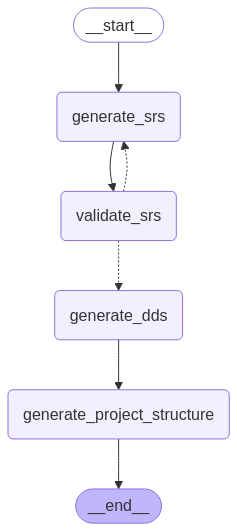

In [16]:
srs_generator_builder = StateGraph(SRSGeneratorState)

srs_generator_builder.add_node("generate_srs", generate_srs)
srs_generator_builder.add_node("validate_srs", validate_srs)
srs_generator_builder.add_node("generate_dds", generate_dds)
srs_generator_builder.add_node("generate_project_structure", generate_project_structure)

srs_generator_builder.add_edge(START, "generate_srs")
srs_generator_builder.add_edge("generate_srs", "validate_srs")
srs_generator_builder.add_conditional_edges("validate_srs", accept_srs, {"generate_dds": "generate_dds", "generate_srs": "generate_srs"})
srs_generator_builder.add_edge("generate_dds", "generate_project_structure")
srs_generator_builder.add_edge("generate_project_structure", END)

srs_generator_graph = srs_generator_builder.compile()

display(Image(srs_generator_graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
srs_result = srs_generator_graph.invoke({"messages": [SystemMessage(content=srs_system_prompt)] + [HumanMessage(content=srs_initial_prompt)],
                                         "iterations": 0})

---GENERATING SRS---
---VALIDATING SRS---
---REWORK SRS---
[4, 5, 5, 4]
---GENERATING SRS---
---VALIDATING SRS---
---SRS ACCEPTED---
---GENERATE DDS---
---GENERATE PROJECT STRUCTURE---


In [26]:
srs_result

{'messages': [SystemMessage(content='You are an experienced software architect. You help with softwer requirements specification (SRS) creation.\nAn SRS is a document containing specifications for a piece of software. It covers the following areas:\n- Problem background\n- Stakeholders / Users\n- Functional requirements\n- Performance requirements\n- Design constraints\n- External interfaces\n- Security requirements\n- Uses cases for the application\n- A glossary of terms\n\nA use case highlights the flow of the application to accomplish a particular purpose. It has the following format:\n- Use case\n    1. Actor\n    2. Purpose\n    3. Event flow\n    4. Special or exceptional requirements', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Please create an SRS for a Snake game with the following requirements:\n- The game should be implemented in Python using the pygame module.\n- The player controls a snake with the goal of eating apples randomly scattered around t